
# SynkroDMX — MIDI Analysis Notebook

This notebook lets you **load a MIDI file**, extract tempo, beats, drum onsets, and a
rough sectioning heuristic, and visualize useful summaries for lighting design.

> Tip: run this in the **SynkroDMX** repo environment where `pretty_midi`, `mido`, `numpy`, and `matplotlib` are installed.


In [1]:

# OPTIONAL: Uncomment to install if needed
# %pip install pretty_midi mido numpy matplotlib

from pathlib import Path
import math
import json
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import pretty_midi
import mido
import matplotlib.pyplot as plt


In [2]:

# --- Configuration ---
# Set your MIDI file path here:
MIDI_PATH = Path("/Users/charly/Downloads/Turnstile-Blackout-03-29-2022.mid")  # <-- change this

assert MIDI_PATH.exists(), f"MIDI not found: {MIDI_PATH}"
print("Using MIDI:", MIDI_PATH)


Using MIDI: /Users/charly/Downloads/Turnstile-Blackout-03-29-2022.mid


In [3]:
def find_drum_instrument_by_name(pm, keywords=None):
    """
    Busca un instrumento de percusión en PrettyMIDI por coincidencia de nombre.

    Parameters
    ----------
    pm : pretty_midi.PrettyMIDI
        Objeto PrettyMIDI cargado.
    keywords : list[str], optional
        Palabras clave a buscar en el nombre. Si None, se usan términos comunes.

    Returns
    -------
    pretty_midi.Instrument or None
        El primer instrumento cuyo nombre coincida, o None si no se encuentra.
    """
    if keywords is None:
        keywords = [
            "drum", "drums", "drumkit", "percussion",
            "batería", "percusión"  # por si acaso en español
        ]
    for inst in pm.instruments:
        if inst.name and any(k.lower() in inst.name.lower() for k in keywords):
            return inst
    return None


# Uso
drum_inst = find_drum_instrument_by_name(pm)
if drum_inst:
    print(f"Encontrada batería: {drum_inst.name} con {len(drum_inst.notes)} notas")
else:
    print("No se encontró batería por nombre.")


NameError: name 'pm' is not defined

In [4]:
import numpy as np
import pretty_midi as pm_lib

pm = pm_lib.PrettyMIDI(str(MIDI_PATH))

# Tempo changes
tempo_times, tempo_bpms = pm.get_tempo_changes()

# Beats
beats = pm.get_beats()

# Duration
duration = pm.get_end_time()

# Instruments
num_instruments = len(pm.instruments)

# Drums: primero canal GM (is_drum), si no hay, buscar por nombre
drum_inst = next((inst for inst in pm.instruments if getattr(inst, "is_drum", False)), None)
if drum_inst is None:
    try:
        drum_inst = find_drum_instrument_by_name(pm)  # <- tu función
    except NameError:
        # Si por cualquier motivo no está definida, no rompemos la celda
        drum_inst = None

# Safe tempo estimate (handles version differences)
try:
    est_bpm = pm.estimate_tempo()  # pretty_midi >= 0.2.x
except AttributeError:
    # Fallback via utilities: estimate_tempo(onset_times)
    from pretty_midi.utilities import estimate_tempo as _estimate_tempo
    onsets = np.array(sorted(n.start for inst in pm.instruments for n in inst.notes))
    est_bpm = float(_estimate_tempo(onsets)) if onsets.size >= 2 else float("nan")

print(f"Duration (s): {duration:.2f}")
print(f"Estimated tempo: {est_bpm:.2f} BPM")
print(f"Tempo changes: {len(tempo_bpms)}")
if len(tempo_bpms) <= 10:
    for t, b in zip(tempo_times, tempo_bpms):
        print(f"  t={t:.2f}s -> {b:.2f} BPM")
else:
    print("  (more than 10; truncated)")

# Time signature changes
ts_changes = getattr(pm, "time_signature_changes", [])
print(f"Time signature changes: {len(ts_changes)}")
for ts in ts_changes[:10]:
    print(f"  t={ts.time:.2f}s -> {ts.numerator}/{ts.denominator}")

print(f"Beats detected: {len(beats)}")
print(f"Instruments: {num_instruments}")
print("Drums present:", bool(drum_inst))
if drum_inst:
    print(f"  Drum instrument name: '{drum_inst.name}' | notes={len(drum_inst.notes)}")


Duration (s): 171.89
Estimated tempo: 261.19 BPM
Tempo changes: 2
  t=0.00s -> 168.00 BPM
  t=125.71s -> 140.00 BPM
Time signature changes: 1
  t=0.00s -> 4/4
Beats detected: 460
Instruments: 6
Drums present: True
  Drum instrument name: 'Drumkit' | notes=1276


/Users/charly/Documents/GitHub/SynkroDMX/.venv/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [12]:
from mido import MidiFile

mf = MidiFile(str(MIDI_PATH))
print("Raw tracks in file:", len(mf.tracks))
for i, tr in enumerate(mf.tracks):
    print(f"  Track {i}: {tr.name} (messages={len(tr)})")

print("\nPrettyMIDI instruments:", len(pm.instruments))
for i, inst in enumerate(pm.instruments):
    kind = "Drums" if inst.is_drum else f"Program {inst.program}"
    print(f"  Inst {i}: name='{inst.name}', channel={getattr(inst, 'midi_channel', 'N/A')}, {kind}, notes={len(inst.notes)}")


Raw tracks in file: 6
  Track 0: Distortion Guitar (messages=3925)
  Track 1: Distortion Guitar (messages=3114)
  Track 2: Distortion Guitar (messages=214)
  Track 3: Electric Bass (messages=1220)
  Track 4: Drumkit (messages=2562)
  Track 5: Singer (messages=640)

PrettyMIDI instruments: 6
  Inst 0: name='Distortion Guitar', channel=N/A, Program 30, notes=1956
  Inst 1: name='Distortion Guitar', channel=N/A, Program 30, notes=1552
  Inst 2: name='Distortion Guitar', channel=N/A, Program 30, notes=102
  Inst 3: name='Electric Bass', channel=N/A, Program 33, notes=605
  Inst 4: name='Drumkit', channel=N/A, Program 0, notes=1276
  Inst 5: name='Singer', channel=N/A, Program 53, notes=189


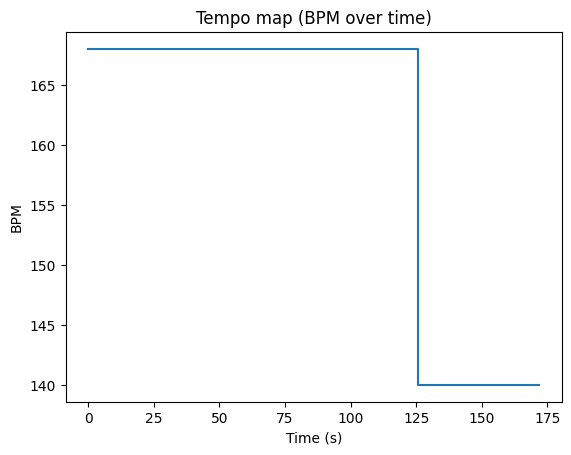

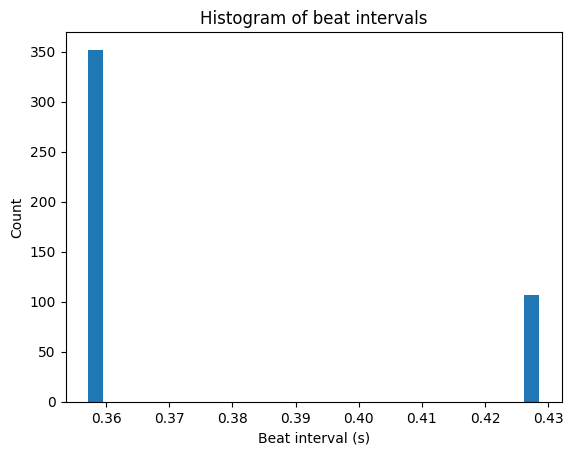

[Beats] N=460  intervals N=459
[Beats] Interval median=0.3571s | mean=0.3738s
[Beats] Estimated BPM (from median interval) ≈ 168.00


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Tempo map (BPM over time) ---
# Construimos un mapa consistente que:
# 1) Arranca en t=0 (si el primer cambio no es 0, lo forzamos)
# 2) Se extiende hasta 'duration' para que el último BPM se vea completo
# 3) Tiene un BPM razonable aunque no haya cambios detectados

# Estimación de BPM de respaldo si hace falta
def _fallback_bpm(pm, beats):
    try:
        return float(pm.estimate_tempo())
    except AttributeError:
        # Estima a partir de onsets (si no hay beats suficientes)
        from pretty_midi.utilities import estimate_tempo as _est
        onsets = np.array(sorted(n.start for inst in pm.instruments for n in inst.notes))
        if onsets.size >= 2:
            return float(_est(onsets))
        # Último recurso: estimar desde beats si hay suficientes
        if beats is not None and len(beats) > 3:
            ivals = np.diff(beats)
            return float(60.0 / np.median(ivals))
        return 120.0  # default razonable

times = list(tempo_times) if len(tempo_times) else []
bpms  = list(tempo_bpms)  if len(tempo_bpms)  else []

if not times:
    # Sin cambios detectados: usar un BPM único
    bpm0 = _fallback_bpm(pm, beats)
    times = [0.0]
    bpms  = [bpm0]

# Asegura inicio en 0.0
if times[0] > 0.0:
    times = [0.0] + times
    bpms  = [bpms[0]] + bpms

# Asegura extensión hasta 'duration'
if times[-1] < duration:
    times = times + [duration]
    bpms  = bpms  + [bpms[-1]]

plt.figure()
plt.step(times, bpms, where="post")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.title("Tempo map (BPM over time)")
plt.show()

# --- Beat interval histogram ---
if len(beats) > 1:
    intervals = np.diff(beats)  # en segundos
    median_int = float(np.median(intervals))
    mean_int = float(np.mean(intervals))
    est_bpm_from_beats = 60.0 / median_int if median_int > 0 else float("nan")

    plt.figure()
    plt.hist(intervals, bins=30)
    plt.xlabel("Beat interval (s)")
    plt.ylabel("Count")
    plt.title("Histogram of beat intervals")
    plt.show()

    print(f"[Beats] N={len(beats)}  intervals N={len(intervals)}")
    print(f"[Beats] Interval median={median_int:.4f}s | mean={mean_int:.4f}s")
    print(f"[Beats] Estimated BPM (from median interval) ≈ {est_bpm_from_beats:.2f}")
else:
    print("Not enough beats to plot interval histogram.")


Drum onsets: 1276
Top drum pitches (MIDI): [(35, 362), (42, 273), (91, 197), (46, 185), (44, 102), (99, 51), (49, 28), (43, 28), (102, 26), (38, 12), (47, 10), (57, 2)]


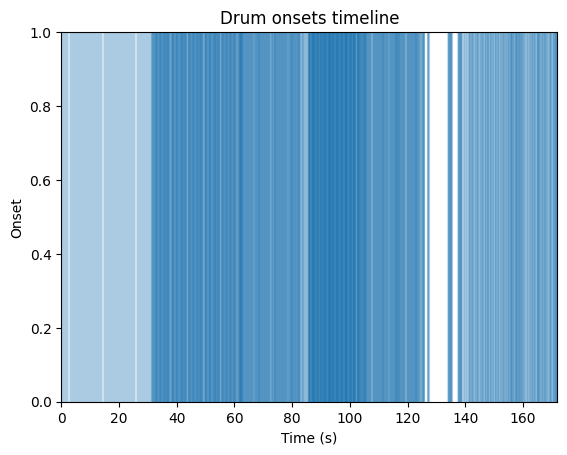

In [6]:

drum_onsets = []
pitch_counts = {}
if drum_inst:
    for n in drum_inst.notes:
        drum_onsets.append(n.start)
        pitch_counts[n.pitch] = pitch_counts.get(n.pitch, 0) + 1

print(f"Drum onsets: {len(drum_onsets)}")
if pitch_counts:
    top = sorted(pitch_counts.items(), key=lambda kv: kv[1], reverse=True)[:12]
    print("Top drum pitches (MIDI):", top)

# Plot drum onsets as vertical lines (if not too many)
if drum_onsets and len(drum_onsets) < 2000:
    plt.figure()
    for t in drum_onsets:
        plt.axvline(t, alpha=0.2)
    plt.xlim(0, duration)
    plt.xlabel("Time (s)")
    plt.ylabel("Onset")
    plt.title("Drum onsets timeline")
    plt.show()


In [7]:
import re
from typing import List, Dict, Tuple
from mido import MidiFile, merge_tracks, tempo2bpm, tick2second

# --- 1) Lectura de marcadores (robusta a versiones de mido) ---
def extract_markers_seconds(midi_path: str) -> List[Tuple[float, str, str]]:
    """
    Devuelve lista de (time_sec, text, type) para metaeventos de interés.
    Soporta archivos con múltiples cambios de tempo.
    """
    mf = MidiFile(midi_path)
    ticks_per_beat = mf.ticks_per_beat

    wanted = {"marker", "text", "track_name", "lyrics", "cue_marker", "cue_point"}
    events = []

    # Fallback seguro: recorrer un único track fusionado y convertir tick->segundo
    # gestionando el tempo actual.
    track = merge_tracks(mf.tracks)
    current_tempo = 500000  # 120 BPM por defecto (microseg/beat)
    abs_ticks = 0

    for msg in track:
        abs_ticks += msg.time  # msg.time está en ticks (delta)
        if msg.type == 'set_tempo':
            # El tempo se aplica a partir de aquí
            current_tempo = msg.tempo
        if msg.is_meta and msg.type in wanted:
            t_sec = tick2second(abs_ticks, ticks_per_beat, current_tempo)
            text = getattr(msg, "text", "").strip()
            events.append((t_sec, text, msg.type))

    # Orden por tiempo
    events.sort(key=lambda x: x[0])
    return events

# --- 2) Normalización de etiquetas ---
_SECTION_PATTERNS = [
    (r'\bintro\b', 'intro'),
    (r'\b(pre[-\s]?chorus|prechorus|pre[-\s]?coro)\b', 'pre-chorus'),
    (r'\b(verse|verso|estrofa)\b', 'verse'),
    (r'\b(chorus|coro|estribillo)\b', 'chorus'),
    (r'\b(bridge|puente)\b', 'bridge'),
    (r'\b(outro|final)\b', 'outro'),
    (r'\b(breakdown|break|drop|build|solo|riff)\b', 'break'),
]

def normalize_section_label(text: str) -> str:
    s = text.lower()
    for pat, name in _SECTION_PATTERNS:
        if re.search(pat, s):
            return name
    # si no matchea nada, devolvemos el texto original "limpio"
    return re.sub(r'\s+', ' ', s).strip()

# --- 3) Construcción de secciones a partir de marcadores ---
def sections_from_markers(midi_path: str, song_duration: float) -> List[Dict]:
    marks = extract_markers_seconds(midi_path)
    # Filtramos marcas vacías
    marks = [(t, txt, typ) for (t, txt, typ) in marks if txt]

    # Normalizamos etiqueta
    norm = [(t, normalize_section_label(txt)) for (t, txt, _) in marks]

    # Si no hay nada utilizable, devolvemos vacío
    if not norm:
        return []

    # Unimos duplicados contiguos del mismo nombre y creamos [start, end)
    norm.sort(key=lambda x: x[0])
    sections = []
    for i, (t, name) in enumerate(norm):
        start = max(0.0, float(t))
        end = float(norm[i+1][0]) if i+1 < len(norm) else float(song_duration)
        # Evita secciones vacías o negativas por etiquetas repetidas en el mismo instante
        if end > start:
            sections.append({"name": name, "start": start, "end": end})
    return sections

# --- 4) Integración con tu pipeline actual ---
# Intentamos leer secciones del MIDI; si no hay, caemos a tu heurística.
sections_meta = sections_from_markers(str(MIDI_PATH), duration)

if sections_meta:
    sections = [(s["name"], s["start"], s["end"]) for s in sections_meta]
    print("Sections (from MIDI markers):")
    for s in sections:
        print(f"  {s[0]:10s} {s[1]:7.2f}s -> {s[2]:7.2f}s (dur={s[2]-s[1]:.2f}s)")
else:
    # --- Tu heurística como fallback ---
    bars = [beats[i] for i in range(0, len(beats), 4)] if len(beats) >= 4 else [0.0, duration]
    note_starts = sorted([n.start for inst in pm.instruments for n in inst.notes])
    densities, edges = [], []
    for i, b in enumerate(bars[:-1]):
        b_next = bars[i+1]
        edges.append((b, b_next))
        lo = np.searchsorted(note_starts, b, side="left")
        hi = np.searchsorted(note_starts, b_next, side="left")
        densities.append(hi - lo)

    sections = []
    if edges:
        n = len(edges)
        k = max(1, n // 4)
        names = ["intro", "verse", "chorus", "bridge"]
        for i in range(0, n, k):
            start = edges[i][0]
            end = edges[min(i + k - 1, n - 1)][1]
            name = names[(i // k) % len(names)]
            sections.append((name, start, end))

    print("Sections (heuristic):")
    for s in sections:
        print(f"  {s[0]:10s} {s[1]:7.2f}s -> {s[2]:7.2f}s (dur={s[2]-s[1]:.2f}s)")


Sections (heuristic):
  intro         0.00s ->   40.00s (dur=40.00s)
  verse        40.00s ->   80.00s (dur=40.00s)
  chorus       80.00s ->  120.00s (dur=40.00s)
  bridge      120.00s ->  166.86s (dur=46.86s)
  intro       166.86s ->  170.29s (dur=3.43s)


Sections (drums-based):
  section_01      0.00s ->   31.43s (dur=31.43s)
  section_02     31.43s ->   61.43s (dur=30.00s)
  section_03     61.43s ->   85.71s (dur=24.29s)
  section_04     85.71s ->  104.29s (dur=18.57s)
  section_05    104.29s ->  124.29s (dur=20.00s)
  section_06    124.29s ->  142.86s (dur=18.57s)
  section_07    142.86s ->  161.71s (dur=18.86s)
  section_08    161.71s ->  171.89s (dur=10.18s)


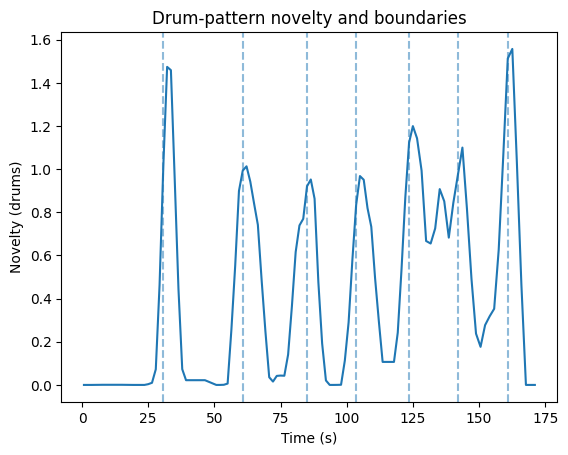

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Utilidades
# -----------------------------
def _gm_drum_class(pitch: int) -> str:
    """Mapeo GM a clases gruesas."""
    if pitch in (35, 36):  # Acoustic/Electric Bass Drum
        return "kick"
    if pitch in (38, 40):  # Snare
        return "snare"
    if pitch in (42, 44, 46):  # Closed/ Pedal / Open Hi-hat
        return "hh"
    if pitch in (41, 43, 45, 47, 48, 50):  # Toms
        return "toms"
    if pitch in (49, 51, 52, 55, 57, 59):  # Cymbals & rides
        return "cym"
    return "other"

def _bars_from_beats(beats, ts_changes, duration, default_num=4):
    """
    Genera lista de inicios de compás (en segundos).
    Usa cambios de compás si existen (numerator); si no, asume 4/4.
    """
    if beats is None or len(beats) == 0:
        return [0.0, duration]
    # Construir segmentos con numerador constante
    segments = []
    if ts_changes:
        # (t_inicio_segmento, numerator)
        for i, ts in enumerate(ts_changes):
            t0 = ts.time
            num = getattr(ts, "numerator", default_num) or default_num
            t1 = ts_changes[i+1].time if (i+1) < len(ts_changes) else duration
            segments.append((t0, t1, int(num)))
    else:
        segments.append((0.0, duration, default_num))

    bars = []
    for (t0, t1, num) in segments:
        # beats dentro del segmento
        lo = np.searchsorted(beats, t0, side="left")
        hi = np.searchsorted(beats, t1, side="left")
        seg_beats = beats[lo:hi]
        if len(seg_beats) == 0:
            continue
        # cada 'num' beats -> 1 compás
        for i in range(0, len(seg_beats), num):
            bars.append(seg_beats[i])
    # Asegura inicio y fin
    if bars[0] > 0.0:
        bars = [0.0] + bars
    if bars[-1] < duration:
        bars = bars + [duration]
    return bars

def _drum_features_per_bar(drum_inst, bar_starts, duration, subdiv=8):
    """
    Extrae features por compás usando SOLO batería.
    Retorna:
      F: array (B x D) con features,
      names: lista de nombres de features,
      bar_edges: lista de (t0, t1)
    Features por compás:
      [kick, snare, hh, toms, cym, other] (cuentas),
      density_total, velocity_mean,
      syncopation_8th (pega fuera de los tiempos 'pares' en rejilla de 8)
    """
    if drum_inst is None or len(drum_inst.notes) == 0:
        return None, None, None

    # Prepara notas de batería
    d_notes = sorted(drum_inst.notes, key=lambda n: n.start)
    onsets = np.array([n.start for n in d_notes], dtype=float)
    pitches = np.array([n.pitch for n in d_notes], dtype=int)
    vels = np.array([getattr(n, "velocity", 100) for n in d_notes], dtype=float)

    # Preclasifica pitches
    cls_map = np.vectorize(_gm_drum_class)(pitches)

    bar_edges = [(bar_starts[i], bar_starts[i+1]) for i in range(len(bar_starts)-1)]
    B = len(bar_edges)
    names = ["kick","snare","hh","toms","cym","other","density","vel_mean","syncop_8"]
    F = np.zeros((B, len(names)), dtype=float)

    for b, (t0, t1) in enumerate(bar_edges):
        lo = np.searchsorted(onsets, t0, side="left")
        hi = np.searchsorted(onsets, t1, side="left")
        if hi <= lo:
            continue
        c = cls_map[lo:hi]
        v = vels[lo:hi]
        t = onsets[lo:hi]

        # cuentas por clase
        for cls_idx, cls_name in enumerate(["kick","snare","hh","toms","cym","other"]):
            F[b, cls_idx] = float(np.sum(c == cls_name))

        # densidad / dinámica
        F[b, 6] = float(hi - lo)  # density_total
        F[b, 7] = float(np.mean(v)) if v.size else 0.0

        # sincronía (off-beat) en rejilla de 8 (0..7), offbeats = impares
        # posición relativa dentro del compás:
        if t1 > t0:
            rel = (t - t0) / (t1 - t0)
            q = (np.round(rel * subdiv).astype(int)) % subdiv
            off_mask = (q % 2 == 1)
            on_mask  = ~off_mask
            # peso por energía (~velocidad). Normaliza por total para comparabilidad
            w_off = float(np.sum(v[off_mask])) if off_mask.any() else 0.0
            w_on  = float(np.sum(v[on_mask]))  if on_mask.any()  else 0.0
            tot = w_off + w_on
            F[b, 8] = (w_off - w_on) / tot if tot > 0 else 0.0

    # Normalizaciones suaves para evitar que la magnitud domine la distancia
    # (z-score por columna con eps)
    eps = 1e-9
    mu = F.mean(axis=0)
    sd = F.std(axis=0)
    sd[sd < eps] = 1.0
    F = (F - mu) / sd
    return F, names, bar_edges

def _novelty_from_features(F, w=4, metric="cosine"):
    """
    Novelty por ventana: distancia entre medias de ventanas izquierda/derecha de tamaño w (en compases).
    """
    B = F.shape[0]
    if B < 2*w + 1:
        return np.zeros(B)
    nov = np.zeros(B)
    for i in range(w, B - w):
        L = F[i-w:i].mean(axis=0)
        R = F[i:i+w].mean(axis=0)
        if metric == "cosine":
            # 1 - cos_sim
            num = float(np.dot(L, R))
            den = float(np.linalg.norm(L) * np.linalg.norm(R)) or 1.0
            nov[i] = 1.0 - (num / den)
        else:
            # L2
            nov[i] = float(np.linalg.norm(L - R))
    # Suavizado ligero
    if B > 5:
        k = 3
        kernel = np.ones(k) / k
        nov = np.convolve(nov, kernel, mode="same")
    return nov

def _peak_pick(nov, q=0.75, min_dist=4):
    """
    Picos por umbral cuantil y distancia mínima en compases.
    Retorna índices de compás (sobre nov) que marcan inicio de sección.
    """
    if len(nov) == 0:
        return []
    thr = np.quantile(nov, q)
    cand = np.where(nov >= thr)[0]
    # filtra por máximos locales
    peaks = []
    for i in cand:
        left  = nov[i-1] if i-1 >= 0 else -np.inf
        right = nov[i+1] if i+1 < len(nov) else -np.inf
        if nov[i] >= left and nov[i] >= right:
            # aplicar separación mínima
            if not peaks or (i - peaks[-1]) >= min_dist:
                peaks.append(int(i))
            elif nov[i] > nov[peaks[-1]]:
                peaks[-1] = int(i)
    return peaks

def segment_sections_from_drums(pm, drum_inst, beats, ts_changes, duration,
                                bars_per_window=4, min_section_bars=8,
                                novelty_quantile=0.75):
    """
    Segmenta exclusivamente por batería.
    Devuelve: sections ([(name,start,end), ...]), debug dict
    """
    bar_starts = _bars_from_beats(beats, ts_changes, duration, default_num=4)
    if len(bar_starts) < 2 or drum_inst is None or len(drum_inst.notes) == 0:
        return [], {"bar_starts": bar_starts, "novelty": np.array([]), "features": None}

    F, feat_names, bar_edges = _drum_features_per_bar(drum_inst, bar_starts, duration)
    if F is None:
        return [], {"bar_starts": bar_starts, "novelty": np.array([]), "features": None}

    nov = _novelty_from_features(F, w=bars_per_window, metric="cosine")
    peaks = _peak_pick(nov, q=novelty_quantile, min_dist=min_section_bars)

    # Construye secciones a partir de picos (índices de compás)
    # Convertimos índices de nov/compás a tiempos
    # Tomamos límites: 0, picos..., último compás
    B = len(bar_edges)
    bounds = [0] + [p for p in peaks if 0 < p < B] + [B]
    bounds = sorted(set(bounds))

    sections = []
    for i in range(len(bounds)-1):
        b0 = bounds[i]
        b1 = bounds[i+1]
        start = bar_edges[b0][0]
        end   = bar_edges[b1-1][1] if (b1-1) < len(bar_edges) else duration
        name = f"section_{i+1:02d}"
        if end > start:
            sections.append((name, start, end))

    dbg = {"bar_starts": bar_starts, "novelty": nov, "features": F, "feat_names": feat_names, "peaks": peaks}
    return sections, dbg

# -----------------------------
# Ejecución
# -----------------------------
sections_drum, dbg = segment_sections_from_drums(
    pm=pm,
    drum_inst=drum_inst,
    beats=beats,
    ts_changes=ts_changes,
    duration=duration,
    bars_per_window=4,     # compara promedios de 4 compases
    min_section_bars=8,    # al menos 8 compases entre cortes
    novelty_quantile=0.75  # umbral por cuantil del novelty
)

# Si quieres que estas sean las secciones "oficiales":
if sections_drum:
    sections = sections_drum

print("Sections (drums-based):")
for name, s, e in sections_drum:
    print(f"  {name:12s} {s:7.2f}s -> {e:7.2f}s (dur={e-s:.2f}s)")

# --- Visualización: novelty + cortes ---
if dbg["novelty"].size > 0:
    bar_mid = [ (a+b)/2.0 for (a,b) in [(dbg["bar_starts"][i], dbg["bar_starts"][i+1]) for i in range(len(dbg["bar_starts"])-1)] ]
    plt.figure()
    plt.plot(bar_mid, dbg["novelty"])
    for p in dbg["peaks"]:
        if 0 <= p-1 < len(bar_mid):
            plt.axvline(bar_mid[p-1], linestyle="--", alpha=0.5)
    plt.xlabel("Time (s)")
    plt.ylabel("Novelty (drums)")
    plt.title("Drum-pattern novelty and boundaries")
    plt.show()


In [12]:

# Build a preview timeline: scene changes at section starts, flash cues on drum onsets
timeline = []
for name, start, end in sections:
    timeline.append({"t": float(start), "type": "scene", "scene": name})

for t in drum_onsets[:50]:
    timeline.append({"t": float(t), "type": "cue", "effect": "flash"})

timeline = sorted(timeline, key=lambda ev: ev["t"])

print(f"Timeline preview events: {len(timeline)} (showing first 40)")

# Save preview to JSON next to the MIDI
out_json = MIDI_PATH.with_suffix(".synkrodmx.preview.json")
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(timeline, f, indent=2)
print("Saved preview JSON ->", out_json)


Timeline preview events: 58 (showing first 40)
Saved preview JSON -> /Users/charly/Downloads/Turnstile-Blackout-03-29-2022.synkrodmx.preview.json


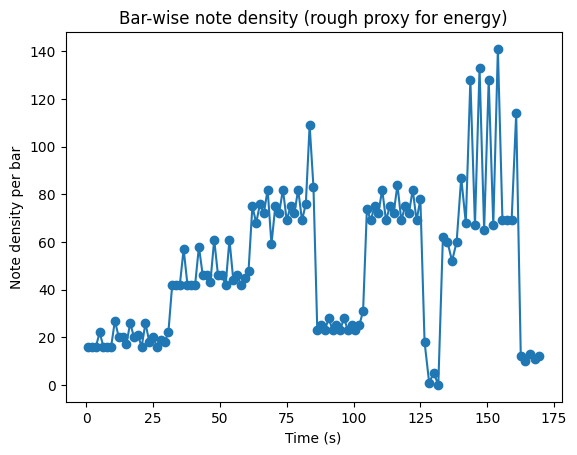

In [10]:

# Visualize note density per bar (rough proxy for energy)
if 'densities' in locals() and densities:
    centers = [(a+b)/2 for a,b in edges]
    plt.figure()
    plt.plot(centers, densities, marker="o")
    plt.xlabel("Time (s)")
    plt.ylabel("Note density per bar")
    plt.title("Bar-wise note density (rough proxy for energy)")
    plt.show()
